In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//30Dor.json"))

pixscale = 0.2 # arcsec
pixscale *= 0.242               # parsec
s0 = (0.242*.92)/2.355              # parsec
m = 1.22

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

(252.11363212022405, 2.7217771927917216)

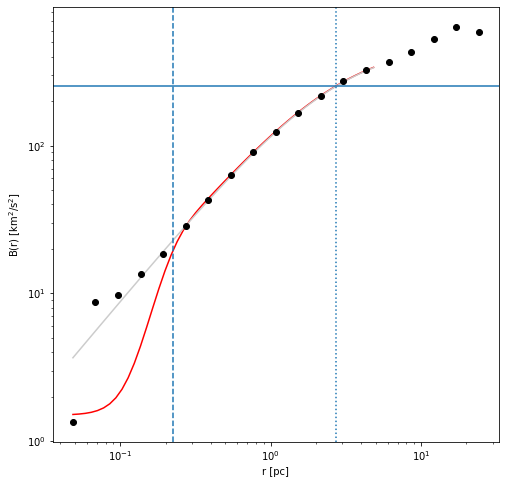

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline( 2.355  * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2,r0

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.10
weights = 1.0 / (relative_uncertainty * B)
weights[0] /= 8.0
weights[1] /= 6.0
weights[2] /= 4.0
weights[3] /= 2.0
weights[4] /= 1.5

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
model02.set_param_hint("sig2", value=sig2, vary=False)
model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan      0.2      inf     True    
sig2    252.114        0      inf    False    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1,
)

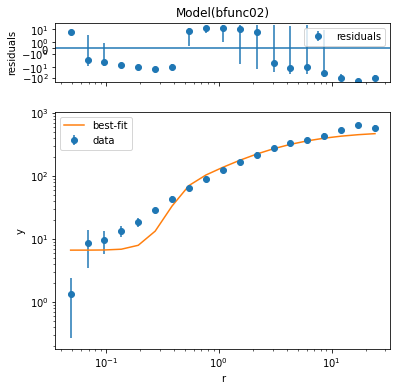

In [10]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);



In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 19
    # variables        = 4
    chi-square         = 101.488502
    reduced chi-square = 6.76590015
    Akaike info crit   = 39.8346242
    Bayesian info crit = 43.6123801
##  Warning: uncertainties could not be estimated:
    s0:     at initial value
    s0:     at boundary
[[Variables]]
    r0:     2.82485710 (init = 2.721777)
    sig2:   252.1136 (fixed)
    m:      1.10105733 (init = 1.22)
    s0:     0.20000000 (init = 0.2)
    noise:  6.67310842 (init = 1)


In [12]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(s0=0.2) = 0.0 < max(sigmas)
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.9895757368155526 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -1.13252  -0.81410  -0.45328   2.82486  +0.66054  +1.86560  +5.20219
 m    :  -0.53694  -0.34407  -0.17217   1.10106  +0.19467  +0.44715  +0.83553
 s0   :      -inf      -inf      -inf   0.20000  +0.00962  +0.04418  +0.13087
 noise:      -inf  -4.97172  -2.35629   6.67311  +2.35332  +4.95828  +8.14569


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 1.0],
    "m": [0.0, 3],
    "r0": [0.0, 17.0],
    "noise": [0.0, 4.0],
}

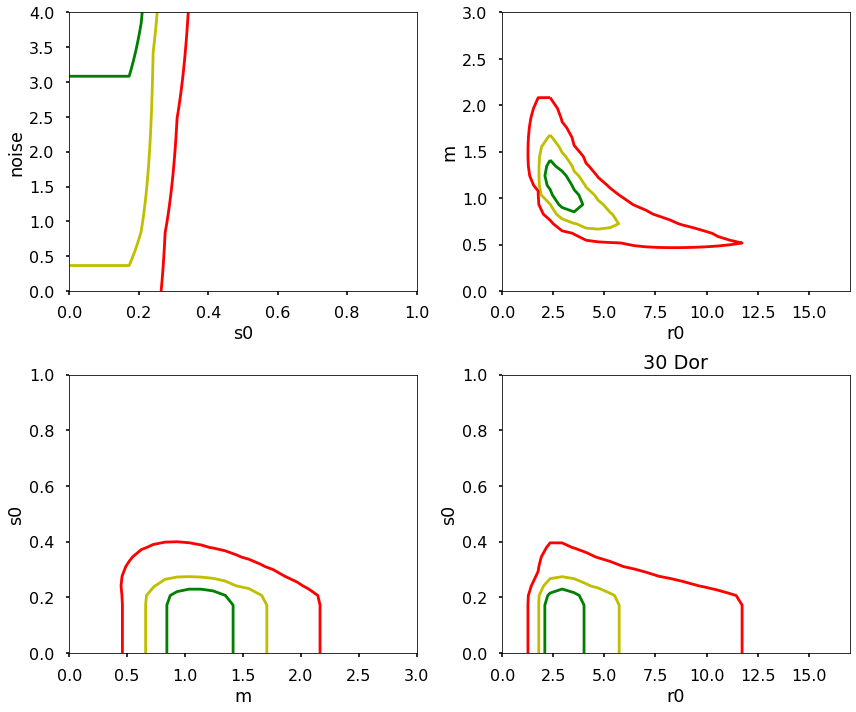

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('30 Dor')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 18.90645408630371 seconds ---
